In [1]:
import os
import numpy as np
import torch
import importlib
import consts
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from scipy.spatial.distance import cdist
from scipy.stats import ortho_group
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis
import pandas as pd
import random
from toolbox.alias_multinomial import AliasMultinomial

# 重新載入 consts 以確保變數最新
importlib.reload(consts)
torch.manual_seed(consts.SEED)
np.random.seed(consts.SEED)

In [2]:
# 確保輸出目錄存在
output_dir = "newsgroup_test"
os.makedirs(output_dir, exist_ok=True)

#下載 20 Newsgroups 資料集並轉換為 BoW
categories = None #下載所有分類的資料
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes')) #移除標題、頁尾及引用，減少雜訊
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
raw_texts = newsgroups_train.data  # ✅ 這是原始文本

vectorizer = CountVectorizer(max_features=5000, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]{3,}\b')#設定文本轉換為bag-of-words，只保留5000個最常出現的單字，移除常見英文停用詞，只允許至少 3 個英文字母的單詞
X_train = vectorizer.fit_transform(newsgroups_train.data).toarray() #將newgroups的資料建立詞彙表(bow)w
X_test = vectorizer.transform(newsgroups_test.data).toarray() #同樣的詞彙表，套用給valid data
#vocab = vectorizer.get_feature_names_out() #所有被納入詞袋單字的單字表
y_train = np.array(newsgroups_train.target) #代表這篇文章屬於哪個分類
y_test = np.array(newsgroups_test.target)

In [3]:
from nltk.tokenize import word_tokenize

# ✅ 修正：確保 raw_texts 為 list，過濾 None 和空字串
tokenized_texts = [word_tokenize(str(doc).lower()) for doc in raw_texts if isinstance(doc, str) and doc.strip()]

# ✅ 檢查 Tokenization 是否成功
print(f"Total Documents: {len(tokenized_texts)}")
print(f"Example Tokenized Texts: {tokenized_texts[:3]}")  # 顯示前 3 個 Tokenized 結果

Total Documents: 11014
Example Tokenized Texts: [['i', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'i', 'saw', 'the', 'other', 'day', '.', 'it', 'was', 'a', '2-door', 'sports', 'car', ',', 'looked', 'to', 'be', 'from', 'the', 'late', '60s/', 'early', '70s', '.', 'it', 'was', 'called', 'a', 'bricklin', '.', 'the', 'doors', 'were', 'really', 'small', '.', 'in', 'addition', ',', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', '.', 'this', 'is', 'all', 'i', 'know', '.', 'if', 'anyone', 'can', 'tellme', 'a', 'model', 'name', ',', 'engine', 'specs', ',', 'years', 'of', 'production', ',', 'where', 'this', 'car', 'is', 'made', ',', 'history', ',', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', ',', 'please', 'e-mail', '.'], ['a', 'fair', 'number', 'of', 'brave', 'souls', 'who', 'upgraded', 'their', 'si', 'clock', 'oscillator', 'have', 'shared', 'their', 'experien

In [23]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

# ✅ 確保 NLTK 停用詞 (stopwords) 可用
nltk.download("stopwords")

# 停用詞列表 (例如 "the", "to", "and" 這些常見詞)
stop_words = set(stopwords.words("english"))

# 設定最大詞彙數量
MAX_VOCAB_SIZE = 5000

# **過濾標點符號、數字、停用詞**
cleaned_texts = []
for doc in tokenized_texts:
    cleaned_doc = [word.lower() for word in doc if word.isalpha() and word.lower() not in stop_words]
    cleaned_texts.append(cleaned_doc)

# 計算詞頻
word_counts = Counter(word for doc in cleaned_texts for word in doc)

# **只保留前 5000 個最常見的詞**
most_common_words = word_counts.most_common(MAX_VOCAB_SIZE)

# **建立詞彙表**
vocab = {word: idx for idx, (word, _) in enumerate(most_common_words)}

# ✅ 打印 vocab 內部示例
print("詞彙表大小:", len(vocab))  # 應該 <= 5000
print("前 10 個詞:", list(vocab.items())[:50])  # 顯示前 10 個詞

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HungLin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


詞彙表大小: 5000
前 10 個詞: [('would', 0), ('one', 1), ('x', 2), ('max', 3), ('people', 4), ('like', 5), ('get', 6), ('know', 7), ('also', 8), ('q', 9), ('use', 10), ('think', 11), ('could', 12), ('time', 13), ('g', 14), ('r', 15), ('new', 16), ('good', 17), ('may', 18), ('well', 19), ('even', 20), ('first', 21), ('see', 22), ('p', 23), ('two', 24), ('much', 25), ('many', 26), ('us', 27), ('make', 28), ('way', 29), ('system', 30), ('god', 31), ('used', 32), ('n', 33), ('say', 34), ('right', 35), ('said', 36), ('want', 37), ('file', 38), ('anyone', 39), ('need', 40), ('work', 41), ('something', 42), ('problem', 43), ('since', 44), ('please', 45), ('w', 46), ('go', 47), ('c', 48), ('information', 49)]


In [ ]:
#產生 word_counts 與 doc_lens
#word_counts = np.sum(X_train, axis=0)
doc_lens_train = np.sum(X_train, axis=1)
doc_lens_test = np.sum(X_test, axis=1)

In [6]:
#轉換為 PyTorch Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

In [59]:
def get_windows_revise(tokenized_texts, vocab, window_size=5, pad_token_idx=0):
    """
    根據原始文本的詞序生成對稱的上下文窗口，讓 pivot_word 在正中央。
    
    Parameters:
    - tokenized_texts (List[List[str]]): 已分詞的文本列表，每個文本是一個詞的列表。
    - vocab (Dict[str, int]): 詞彙表，映射詞到索引，例如 {"apple": 0, "banana": 1, ...}
    - window_size (int): 窗口大小（應該是奇數，以確保 pivot_word 在正中央）。
    
    Returns:
    - np.array: 每行為 [doc_idx, pivot_word, context_word1, context_word2, ...]
    """
    assert window_size % 2 == 1
    half_window = window_size // 2  # 左右各取 `half_window` 個詞
    context_size = 2 * half_window
    total_len = 1 + 1 + context_size

    windows = []

    for doc_idx, tokens in enumerate(tokenized_texts):
        indexed_tokens = [vocab[word] for word in tokens if word in vocab]  # 將文本轉換為索引
        
        if len(indexed_tokens) >= 2:  # 確保至少有兩個詞
            for i in range(len(indexed_tokens)):
                pivot = indexed_tokens[i]  # 中心詞
                
                # 計算前後詞的範圍，確保不超出文本範圍
                start_idx = max(0, i - half_window)  # 確保索引不低於 0
                end_idx = min(len(indexed_tokens), i + half_window + 1)  # 確保索引不超過最大範圍
                
                context = indexed_tokens[start_idx:i] + indexed_tokens[i + 1:end_idx]  # 前後取詞

                while len(context) < context_size:
                    context.append(pad_token_idx)
                    
                windows.append([doc_idx, pivot] + context)  # 輸出格式：[doc_idx, pivot_word, context_word1, ...]

    return np.array(windows, dtype=np.int64)  # 使用 dtype=object 以防長度不一致

In [60]:
# 生成前後對稱的上下文窗口
doc_windows_revise = get_windows_revise(tokenized_texts, vocab, window_size=5)

# 查看窗口數據
print(doc_windows_revise[:5])  # 只顯示前 5 個窗口

[[   0 1060   39   12    0    0]
 [   0   39 1060   12  157    0]
 [   0   12 1060   39  157  377]
 [   0  157   39   12  377  139]
 [   0  377   12  157  139 2127]]


In [ ]:
# 建立 vocab 的反向字典
index_to_word = {idx: word for word, idx in vocab.items()}

# 轉換數字回詞
def decode_window(window):
    doc_idx = window[0]
    pivot_word = index_to_word[window[1]] if window[1] in index_to_word else "<UNK>"
    context_words = [index_to_word[idx] if idx in index_to_word else "<UNK>" for idx in window[2:]]
    return [doc_idx, pivot_word] + context_words

# 測試解碼
decoded_windows = [decode_window(window) for window in doc_windows_revise[:5]]
for w in decoded_windows:
    print(w)

[0, 'wondering', 'anyone', 'could', 'would', 'would']
[0, 'anyone', 'wondering', 'could', 'car', 'would']
[0, 'could', 'wondering', 'anyone', 'car', 'saw']
[0, 'car', 'anyone', 'could', 'saw', 'day']
[0, 'saw', 'could', 'car', 'day', 'sports']


In [62]:
raw_texts[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [63]:
def set_seed(seed=9527):
    """
    設置隨機種子，確保結果可重現。
    
    Parameters:
    - seed (int): 隨機種子數值
    """
    random.seed(seed)  # 設置 Python 內建 random 庫的種子
    np.random.seed(seed)  # 設置 NumPy 的隨機種子
    torch.manual_seed(seed)  # 設置 PyTorch 的隨機種子
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # 設置 GPU 隨機種子
        torch.cuda.manual_seed_all(seed)  # 設置所有 GPU 的隨機種子
        torch.backends.cudnn.deterministic = True  # 確保 cuDNN 生成的結果可重現
        torch.backends.cudnn.benchmark = False  # 禁用 cuDNN 自適應優化，確保可重現性

In [64]:
#自訂 PyTorch Dataset，將已產生的上下文資料，包裝成pytorch可使用的資料集物件
class DocWindowsDataset(Dataset):
    def __init__(self, windows):
        self.data = windows

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.long)

In [65]:
#概念挖掘模型
class GuidedDiverseConceptMiner(nn.Module):
    def __init__(self, vocab, vocab_size, nconcepts=10, embed_dim=50, nnegs=15, bow_train=None, y_train=None, doc_windows=None, word_counts=None, seed=9527):
        super(GuidedDiverseConceptMiner, self).__init__() #呼叫父類別(nn.Module)
        set_seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #device = torch.device(self.device)

        self.vocab_dict = vocab
        self.vocab=list(vocab.keys())
        self.nconcepts = nconcepts
        self.nnegs = nnegs
        vocab_size = len(self.vocab)
        
        self.embedding_i = nn.Embedding(vocab_size, embed_dim).to(self.device) #word embedding
        self.embedding_t = nn.Parameter(torch.FloatTensor(ortho_group.rvs(embed_dim)[0:nconcepts])).to(self.device) #concept embedding
        self.doc_concept_weights = nn.Embedding(bow_train.shape[0], nconcepts).to(self.device)
        self.docweights = torch.ones(bow_train.shape[0], dtype=torch.float32, device=self.device)
        self.train_dataset = DocWindowsDataset(doc_windows_revise)
        #self.dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(nconcepts, 1).to(self.device)
        self.bow_train = torch.tensor(bow_train, dtype=torch.float32, requires_grad=False, device=self.device)

        #negative sampling的權重
        #self.word_counts=word_counts
        word_freq_array = np.array([word_counts.get(word, 1) for word in vocab.keys()])
        wf = np.power(word_freq_array, 0.75) #將每個單字的出現次數取0.75次方
        wf = wf / np.sum(wf) #正規化，使所有值的總和為1，得到一個機率分布
        self.weights = torch.tensor(wf, dtype=torch.float32, requires_grad=False, device=device) #把numpy陣列轉成tensor
        
        self.dropout1 = nn.Dropout(consts.PIVOTS_DROPOUT)
        self.dropout2 = nn.Dropout(consts.DOC_VECS_DROPOUT)
        self.multinomial = AliasMultinomial(wf, self.device) #在wf形成的分布上進行multinomial抽樣
    
    def forward(self, doc, target, contexts):
        batch_size = contexts.size(0)
        window_size = contexts.size(1)
        
        #用文件長度重新調整loss權重
        w = autograd.Variable(self.docweights[doc.data]).to(self.device)
        w /= w.sum()
        w *= w.size(0)

        #vd = Ec * pd
        doc_concept_probs = F.softmax(self.doc_concept_weights(doc), dim=1).to(self.device) #計算每個文件與不同概念的關聯程度
        concept_embeddings = self.embedding_t.expand(batch_size, -1, -1) #把embedding_t(概念向量)展開，讓它的形狀從(nnconcepts, embed_dim)，變成(batch_size, nnconcepts, embed_dim)，為了下一步torch.bmm的計算
        doc_vector = torch.bmm(doc_concept_probs.unsqueeze(1), concept_embeddings).squeeze(1) #doc_vector，代表每個文件的最終向量表示，用來計算概念權重，影響預測結果。(batch_size, 1, nnconcepts) x (batch_size, nnconcepts, embed_dim) = (batch_size, 1, embed_dim)
        
        #sample negative word indices for negative sampling loss; approximation by sampling from the whole vocab
        nwords = self.multinomial.draw(batch_size * window_size * self.nnegs)
        nwords = autograd.Variable(nwords).view(batch_size, window_size * self.nnegs)

        #計算word vectors
        ivectors = self.dropout1(self.embedding_i(target)) #目標詞向量
        ovectors = self.embedding_i(contexts) #上下文詞向量
        nvectors = self.embedding_i(nwords).neg() #負樣本詞向量

        context_vectors = doc_vector + ivectors
        context_vectors = context_vectors.unsqueeze(2)

        #計算negative sampling loss
        oloss = torch.bmm(ovectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        nloss = torch.bmm(nvectors, context_vectors).squeeze(dim=2).sigmoid().clamp(min=1e-9).log().sum(1)
        negative_sampling_loss = (oloss + nloss).neg()
        negative_sampling_loss *= w
        negative_sampling_loss = negative_sampling_loss.mean()
        
        pred_weight = self.linear(doc_concept_probs)
        return pred_weight, negative_sampling_loss

    def fit(self, lr=0.01, nepochs=10, batch_size=100):
        train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(nepochs):
            total_loss = 0.0
            total_neg_sampling_loss = 0.0
            num_batches = 0

            self.train()
            for batch in train_dataloader:
                batch = batch.long().to(self.device)
                doc, target, contexts = batch[:, 0], batch[:, 1], batch[:, 2:]
                pred, neg_sampling_loss = self(doc.to(self.device), target.to(self.device), contexts.to(self.device))
                loss = neg_sampling_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_neg_sampling_loss += neg_sampling_loss.item()
                num_batches += 1
                
            avg_loss = total_loss / num_batches
            avg_neg_sampling_loss = total_neg_sampling_loss / num_batches
            print(f"Epoch {epoch + 1}/{nepochs} - Loss: {avg_loss:.4f}, Neg Sampling Loss: {avg_neg_sampling_loss:.4f}")

    def visualize(self, top_k=10, concept_dist='dot'):
        """
        可視化每個概念的關鍵詞詞雲。

        Parameters:
        - top_k: 每個概念取前 K 個相關詞
        - concept_dist: 計算概念與詞語之間的距離 ('dot', 'cosine', 'euclidean' 等)
        """
        wordcloud = WordCloud(width=800, height=400, background_color='white')

        # 取得每個概念的前 K 個關鍵詞
        concept_words_list = self.get_concept_words(top_k=top_k, concept_dist=concept_dist)

        for i, concept_words in enumerate(concept_words_list):
            # 為詞雲創建詞頻字典（每個詞的頻率設為固定值，確保詞雲可視化）
            concept_word_freqs = {word: 1.0 for word in concept_words}

            # 生成詞雲
            wc = wordcloud.generate_from_frequencies(concept_word_freqs)

            # 顯示詞雲
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Concept {i+1}")
            plt.show()
        
    def get_concept_words(self, top_k=10, concept_dist='dot'):
        """
        獲取每個概念最相關的詞彙。

        Parameters:
        - top_k: 每個概念取前 K 個相關的詞
        - concept_dist: 計算概念與詞語之間距離的方法
                    (可選: 'dot', 'cosine', 'euclidean' 等)

        Returns:
        - concepts (List[List[str]]): 每個概念對應的關鍵詞列表
        """
        # 取得概念與詞嵌入矩陣
        concept_embed = self.embedding_t.data.cpu().numpy()
        word_embed = self.embedding_i.weight.data.cpu().numpy()

        # 計算距離或相似度（越小越相似）
        if concept_dist == 'dot':
            dist = -np.matmul(concept_embed, word_embed.T)  # dot 越大越相似 → 加負號排序用
        else:
            dist = cdist(concept_embed, word_embed, metric=concept_dist)  # cosine, euclidean 等

        # 每個概念找出前 top_k 個最相似的詞索引
        nearest_word_idxs = np.argsort(dist, axis=1)[:, :top_k]

        # 建立 index → word 的反查表
        inv_vocab = {idx: word for word, idx in self.vocab_dict.items()}

        # 將索引轉換為對應的詞
        concepts = []
        for j in range(self.nconcepts):
            nearest_words = [inv_vocab[i] for i in nearest_word_idxs[j] if i in inv_vocab]
            concepts.append(nearest_words)

        return concepts

In [66]:
# ✅ 訓練模型
gdcm = GuidedDiverseConceptMiner(
    vocab=vocab,
    vocab_size=len(vocab),
    bow_train=X_train_tensor.cpu().numpy(),
    y_train=y_train_tensor.cpu().numpy(),
    doc_windows=doc_windows_revise,
    word_counts=word_counts,
    seed=9527
)

In [68]:
gdcm.fit(nepochs=5, batch_size=100)

Epoch 1/5 - Loss: 48.5896, Neg Sampling Loss: 48.5896
Epoch 2/5 - Loss: 38.4739, Neg Sampling Loss: 38.4739
Epoch 3/5 - Loss: 38.4109, Neg Sampling Loss: 38.4109
Epoch 4/5 - Loss: 38.3980, Neg Sampling Loss: 38.3980
Epoch 5/5 - Loss: 38.3962, Neg Sampling Loss: 38.3962


In [70]:
# 查看詞彙表的前 50 個單詞
print("Vocabulary sample:", list(vocab.items())[:50])

# 檢查概念關鍵詞的選擇
concepts = gdcm.get_concept_words(top_k=10, concept_dist="cosine")
for i, concept_words in enumerate(concepts):
    print(f'Concept {i+1}: {concept_words}')

Vocabulary sample: [('would', 0), ('one', 1), ('x', 2), ('max', 3), ('people', 4), ('like', 5), ('get', 6), ('know', 7), ('also', 8), ('q', 9), ('use', 10), ('think', 11), ('could', 12), ('time', 13), ('g', 14), ('r', 15), ('new', 16), ('good', 17), ('may', 18), ('well', 19), ('even', 20), ('first', 21), ('see', 22), ('p', 23), ('two', 24), ('much', 25), ('many', 26), ('us', 27), ('make', 28), ('way', 29), ('system', 30), ('god', 31), ('used', 32), ('n', 33), ('say', 34), ('right', 35), ('said', 36), ('want', 37), ('file', 38), ('anyone', 39), ('need', 40), ('work', 41), ('something', 42), ('problem', 43), ('since', 44), ('please', 45), ('w', 46), ('go', 47), ('c', 48), ('information', 49)]
Concept 1: ['sins', 'steps', 'except', 'statistical', 'setup', 'explanations', 'learn', 'community', 'mexico', 'waste']
Concept 2: ['become', 'former', 'argic', 'unto', 'london', 'academic', 'name', 'registration', 'assault', 'serdar']
Concept 3: ['would', 'said', 'one', 'going', 'experience', 'came

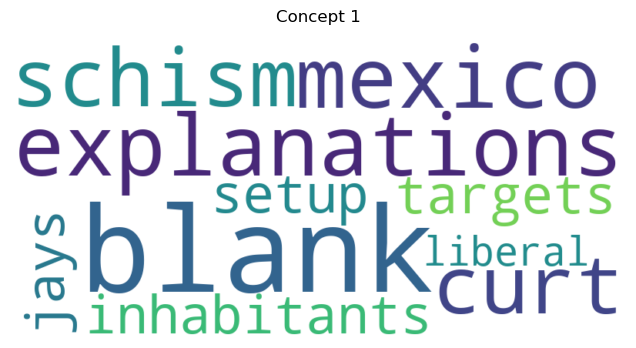

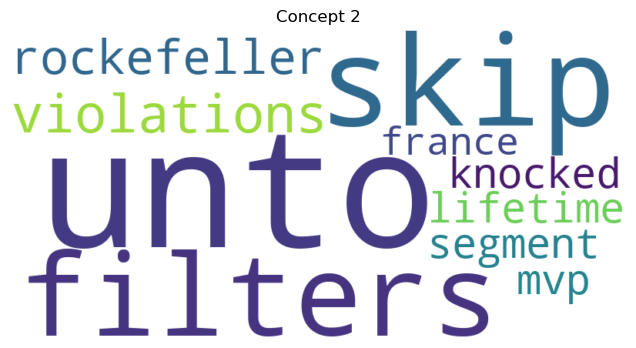

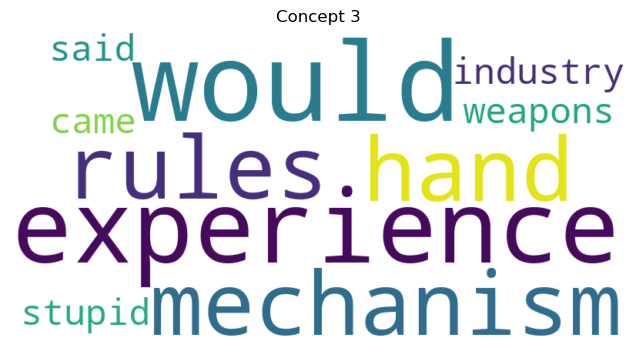

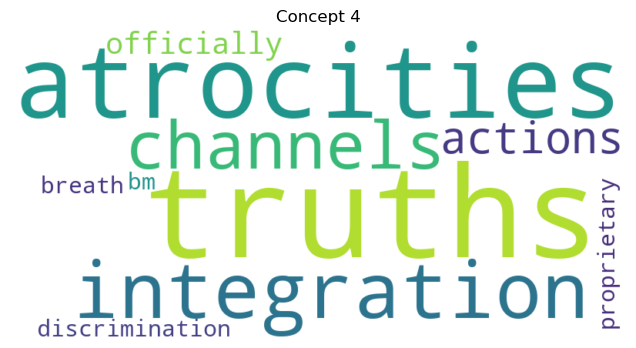

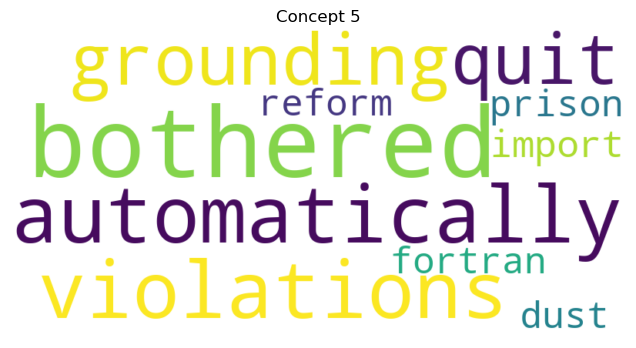

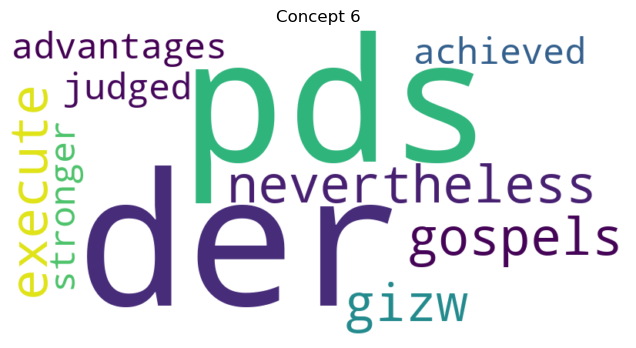

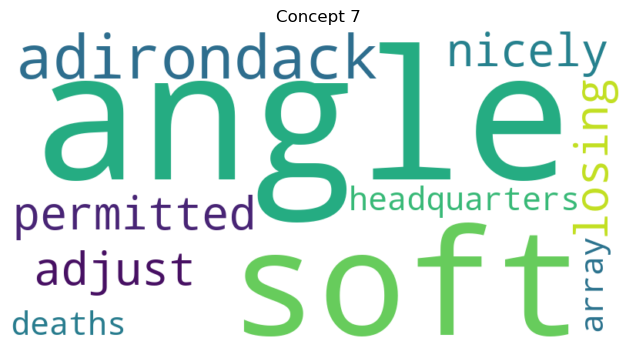

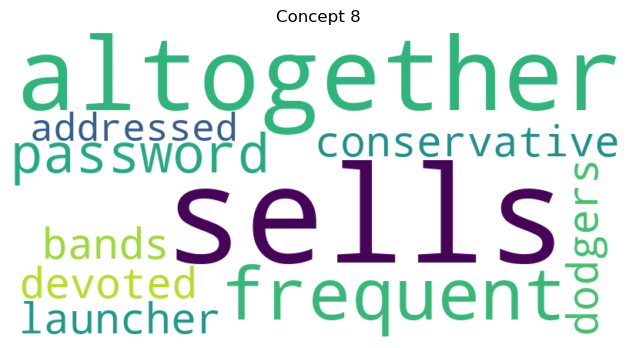

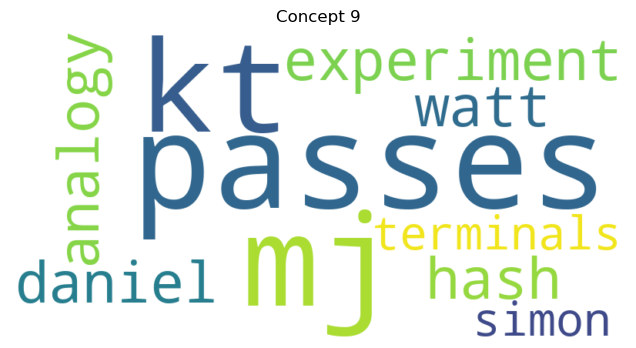

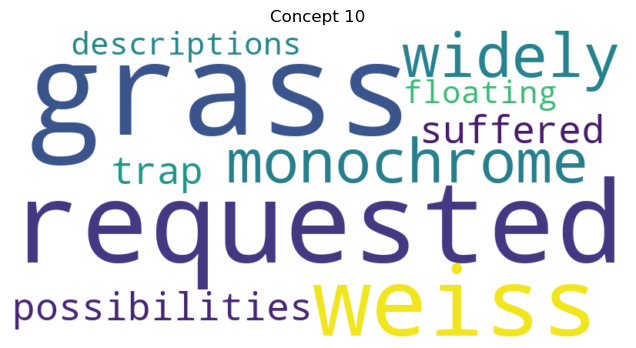

In [71]:
# ✅ 產生概念視覺化
gdcm.visualize()

In [72]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def compute_coherence(concept_words_list, texts, method="c_v"):
    """
    計算概念內的詞彙 Coherence。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念內的關鍵詞（`get_concept_words()` 提供）
    - texts: List[List[str]]，原始文本分詞（用於計算 Coherence）
    - method: "c_v", "c_uci", "c_npmi"（選擇不同 Coherence 方法）

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_scores = []
    for concept_words in concept_words_list:
        cm = CoherenceModel(topics=[concept_words], texts=texts, dictionary=dictionary, coherence=method)
        coherence_scores.append(cm.get_coherence())
    
    return coherence_scores

In [73]:
concept_words_list = gdcm.get_concept_words(top_k=10, concept_dist="cosine")  # 取得概念內的詞
texts = [text.split() for text in newsgroups_train.data]  # 轉換文本為 token
coherence_scores = compute_coherence(concept_words_list, texts, method="c_npmi")

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Coherence: {score:.4f}")

Concept 1 Coherence: -0.3980
Concept 2 Coherence: -0.2250
Concept 3 Coherence: -0.1032
Concept 4 Coherence: -0.3753
Concept 5 Coherence: -0.3424
Concept 6 Coherence: -0.4090
Concept 7 Coherence: -0.3024
Concept 8 Coherence: -0.2994
Concept 9 Coherence: -0.3592
Concept 10 Coherence: -0.2640


In [74]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_coherence(concept_words_list, word_vectors):
    """
    計算每個概念內詞向量的平均餘弦相似度，評估內聚性。

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - word_vectors: dict，詞向量字典，例如 Word2Vec/GloVe/BERT 的 embeddings

    Returns:
    - coherence_scores: List[float]，每個概念的平均相似度
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        vectors = [word_vectors[word] for word in concept_words if word in word_vectors]
        
        if len(vectors) < 2:
            coherence_scores.append(0)  # 如果概念內少於 2 個詞，設為 0
            continue
        
        similarity_matrix = cosine_similarity(vectors)
        avg_similarity = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean()
        coherence_scores.append(avg_similarity)
    
    return coherence_scores

In [75]:
# 獲取詞向量
word_vectors = {word: gdcm.embedding_i.weight.data.cpu().numpy()[idx] for idx, word in enumerate(vocab)}

# 計算 Coherence
cosine_coherence_scores = compute_cosine_coherence(concept_words_list, word_vectors)

for i, score in enumerate(cosine_coherence_scores):
    print(f"Concept {i+1} Cosine Coherence: {score:.4f}")

Concept 1 Cosine Coherence: 0.2232
Concept 2 Cosine Coherence: 0.3052
Concept 3 Cosine Coherence: 0.1598
Concept 4 Cosine Coherence: 0.2403
Concept 5 Cosine Coherence: 0.3163
Concept 6 Cosine Coherence: 0.2634
Concept 7 Cosine Coherence: 0.2253
Concept 8 Cosine Coherence: 0.2392
Concept 9 Cosine Coherence: 0.2631
Concept 10 Cosine Coherence: 0.3061


In [76]:
from itertools import combinations

def compute_jaccard_coherence(concept_words_list, texts):
    """
    計算 Jaccard Similarity 作為 Coherence 分數。
    
    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞
    
    Returns:
    - coherence_scores: List[float]，每個概念的 Jaccard 相似度平均值
    """
    coherence_scores = []
    
    for concept_words in concept_words_list:
        pairs = list(combinations(concept_words, 2))  # 生成所有單詞對
        
        jaccard_scores = []
        for w1, w2 in pairs:
            docs_w1 = {i for i, doc in enumerate(texts) if w1 in doc}
            docs_w2 = {i for i, doc in enumerate(texts) if w2 in doc}
            
            intersection = len(docs_w1 & docs_w2)
            union = len(docs_w1 | docs_w2)
            
            if union == 0:
                jaccard_scores.append(0)
            else:
                jaccard_scores.append(intersection / union)
        
        coherence_scores.append(np.mean(jaccard_scores) if jaccard_scores else 0)
    
    return coherence_scores

In [77]:
jaccard_coherence_scores = compute_jaccard_coherence(concept_words_list, texts)

for i, score in enumerate(jaccard_coherence_scores):
    print(f"Concept {i+1} Jaccard Coherence: {score:.4f}")

Concept 1 Jaccard Coherence: 0.0092
Concept 2 Jaccard Coherence: 0.0088
Concept 3 Jaccard Coherence: 0.0569
Concept 4 Jaccard Coherence: 0.0142
Concept 5 Jaccard Coherence: 0.0113
Concept 6 Jaccard Coherence: 0.0065
Concept 7 Jaccard Coherence: 0.0211
Concept 8 Jaccard Coherence: 0.0094
Concept 9 Jaccard Coherence: 0.0082
Concept 10 Jaccard Coherence: 0.0171


In [78]:
from collections import defaultdict
import numpy as np

def compute_mimno_coherence(concept_words_list, texts):
    """
    Mimno 和 McCallum (2008) Coherence 計算方式，避免 division by zero 錯誤

    Parameters:
    - concept_words_list: List[List[str]]，每個概念的關鍵詞
    - texts: List[List[str]]，原始文本分詞後的列表

    Returns:
    - coherence_scores: List[float]，每個概念的 Coherence 值
    """
    # 記錄每個詞在哪些文件中出現
    doc_word_counts = defaultdict(set)  # 用 set 存儲詞的文件索引
    for i, text in enumerate(texts):
        for word in set(text):  # 轉換為 set，避免重複計數
            doc_word_counts[word].add(i)

    coherence_scores = []
    for concept_words in concept_words_list:
        pairs = [(w1, w2) for i, w1 in enumerate(concept_words) for w2 in concept_words[i+1:]]
        coherence = []
        for w1, w2 in pairs:
            D_w1 = len(doc_word_counts[w1])  # 包含 w1 的文件數量
            D_w1_w2 = len(doc_word_counts[w1] & doc_word_counts[w2])  # 同時包含 w1 和 w2 的文件數量
            
            # **防止 division by zero**
            if D_w1 == 0:
                continue  # 如果 w1 不在任何文檔中，跳過這個詞對
            
            score = np.log((D_w1_w2 + 1) / (D_w1 + 1e-10))  # 加一個小的數值避免除零錯誤
            coherence.append(score)

        coherence_scores.append(np.mean(coherence) if coherence else -np.inf)  # 避免空列表報錯

    return coherence_scores

In [79]:
mimno_coherence_scores = compute_mimno_coherence(concept_words_list, texts)

for i, score in enumerate(coherence_scores):
    print(f"Concept {i+1} Mimno Coherence: {score:.4f}")

Concept 1 Mimno Coherence: -0.3980
Concept 2 Mimno Coherence: -0.2250
Concept 3 Mimno Coherence: -0.1032
Concept 4 Mimno Coherence: -0.3753
Concept 5 Mimno Coherence: -0.3424
Concept 6 Mimno Coherence: -0.4090
Concept 7 Mimno Coherence: -0.3024
Concept 8 Mimno Coherence: -0.2994
Concept 9 Mimno Coherence: -0.3592
Concept 10 Mimno Coherence: -0.2640
